# Day 2: Data Cleaning Pipeline

## Tujuan
Membersihkan dataset fintech customer messages untuk memastikan:
- Tidak ada duplikasi
- Format teks konsisten (whitespace, punctuation)
- Sesuai constraint panjang (20-300 chars)
- Bahasa target (Indonesian)
- Siap untuk labeling manual

## Output
- `data/processed/cleaned_data.jsonl`: Data bersih
- `data/processed/validation_report.json`: Hasil validasi
- `data/processed/cleaning_log.csv`: Log statistik
- Visualisasi cleaning funnel

## 1. Setup Environment

In [1]:
import pandas as pd
import numpy as np
import yaml
import json
import jsonlines
import hashlib
import re
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, LangDetectException

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Cleaning pipeline started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Cleaning pipeline started: 2025-12-19 10:07:27


## 2. Load Configuration

In [2]:
# Load pipeline config
config_path = Path('../configs/pipeline_config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Cleaning Configuration:")
print(f"  Min length: {config['cleaning']['min_length']}")
print(f"  Max length: {config['cleaning']['max_length']}")
print(f"  Target language: {config['cleaning']['target_language']}")
print(f"  Remove duplicates: {config['cleaning']['remove_duplicates']}")
print(f"  Normalize text: {config['cleaning']['normalize_text']}")
print(f"  Remove emojis: True")  

Cleaning Configuration:
  Min length: 20
  Max length: 300
  Target language: id
  Remove duplicates: True
  Normalize text: True
  Remove emojis: True


## 3. Load Raw Data

In [3]:
# Load raw CSV
raw_path = Path('../data/raw/synthetic_generated.csv')
df_raw = pd.read_csv(raw_path, header=None, names=['id', 'text'])

print(f"Raw data loaded: {len(df_raw)} messages")
print(f"Sample:")
print(df_raw.head(3))

# Initialize statistics tracker
stats = {
    'step': [],
    'count': [],
    'removed': [],
    'percentage': []
}

def track_stats(step_name, df):
    current_count = len(df)
    if len(stats['count']) > 0:
        removed = stats['count'][-1] - current_count
    else:
        removed = 0
    
    stats['step'].append(step_name)
    stats['count'].append(current_count)
    stats['removed'].append(removed)
    stats['percentage'].append(current_count / len(df_raw) * 100)
    
    print(f"  {step_name}: {current_count} messages (removed: {removed})")

track_stats('Raw data', df_raw)

Raw data loaded: 555 messages
Sample:
        id                                            text
0  msg_117  transaksi gagal tapi duit udh kepotong bangsat
1  msg_355   akun di suspend tiba2 padahal baru top up 1jt
2  msg_301              fitur cicilan 0% masih ada ga min?
  Raw data: 555 messages (removed: 0)


## 4. Step 1: Remove Duplicates

Menggunakan MD5 hash untuk detect exact duplicates

In [4]:
print("\n=== STEP 1: Remove Duplicates ===")

# Create hash for duplicate detection
df_raw['text_hash'] = df_raw['text'].apply(
    lambda x: hashlib.md5(x.encode()).hexdigest()
)

# Find duplicates before removal
duplicate_mask = df_raw.duplicated(subset='text_hash', keep='first')
duplicates_found = duplicate_mask.sum()

print(f"Duplicates found: {duplicates_found}")

# Show duplicate examples
if duplicates_found > 0:
    print("\nDuplicate examples:")
    dup_groups = df_raw[df_raw.duplicated(subset='text_hash', keep=False)].groupby('text_hash')
    for hash_val, group in list(dup_groups)[:3]:
        print(f"  IDs: {group['id'].tolist()}")
        print(f"  Text: {group['text'].iloc[0][:80]}...\n")

# Remove duplicates
df_clean = df_raw.drop_duplicates(subset='text_hash', keep='first').copy()
df_clean = df_clean.drop(columns=['text_hash'])

track_stats('After deduplication', df_clean)


=== STEP 1: Remove Duplicates ===
Duplicates found: 395

Duplicate examples:
  IDs: ['msg_437', 'msg_396', 'msg_402', 'msg_385', 'msg_353', 'msg_435', 'msg_362', 'msg_380', 'msg_438']
  Text: urgent banget nih transaksi nyangkut 4jt...

  IDs: ['msg_492', 'msg_495', 'msg_474']
  Text: puas sih pake gopay selama ini lancar...

  IDs: ['msg_073', 'msg_116']
  Text: REFUND GW MANA KONTOL UDAH SEMINGGU??????...

  After deduplication: 160 messages (removed: 395)


## 5. Step 2: Normalize Text

- Trim whitespace
- Normalize multiple spaces
- Normalize excessive punctuation

In [5]:
print("\n=== STEP 2: Normalize Text ===")

# Show examples before normalization
print("Examples BEFORE normalization:")
sample_idx = [0, 1, 2]
for idx in sample_idx:
    if idx < len(df_clean):
        print(f"  [{df_clean.iloc[idx]['id']}]: '{df_clean.iloc[idx]['text'][:60]}'")

# Define normalization functions
def normalize_whitespace(text):
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    return text

def normalize_punctuation(text):
    text = re.sub(r'\.{6,}', '.....', text)
    text = re.sub(r'!{6,}', '!!!!!', text)
    text = re.sub(r'\?{4,}', '???', text)
    return text

# ✅ ADD THIS FUNCTION
def remove_emojis(text):
    """Remove emoji and other non-ASCII characters"""
    # Keep only ASCII characters
    return text.encode('ascii', 'ignore').decode('ascii').strip()

# Apply normalizations
df_clean['text'] = df_clean['text'].apply(normalize_whitespace)
df_clean['text'] = df_clean['text'].apply(normalize_punctuation)
df_clean['text'] = df_clean['text'].apply(remove_emojis)  

print("\nExamples AFTER normalization:")
for idx in sample_idx:
    if idx < len(df_clean):
        print(f"  [{df_clean.iloc[idx]['id']}]: '{df_clean.iloc[idx]['text'][:60]}'")

track_stats('After normalization', df_clean)  


=== STEP 2: Normalize Text ===
Examples BEFORE normalization:
  [msg_117]: 'transaksi gagal tapi duit udh kepotong bangsat'
  [msg_355]: 'akun di suspend tiba2 padahal baru top up 1jt'
  [msg_301]: 'fitur cicilan 0% masih ada ga min?'

Examples AFTER normalization:
  [msg_117]: 'transaksi gagal tapi duit udh kepotong bangsat'
  [msg_355]: 'akun di suspend tiba2 padahal baru top up 1jt'
  [msg_301]: 'fitur cicilan 0% masih ada ga min?'
  After normalization: 160 messages (removed: 0)


## 6. Step 3: Filter by Length

Keep only messages within length constraints

In [6]:
print("\n=== STEP 3: Filter by Length ===")

# Calculate lengths
df_clean['text_length'] = df_clean['text'].str.len()

# Check constraint violations
min_len = config['cleaning']['min_length']
max_len = config['cleaning']['max_length']

too_short = df_clean[df_clean['text_length'] < min_len]
too_long = df_clean[df_clean['text_length'] > max_len]

print(f"Length constraints: {min_len}-{max_len} characters")
print(f"  Too short (<{min_len}): {len(too_short)}")
print(f"  Too long (>{max_len}): {len(too_long)}")

# Show examples of filtered messages
if len(too_short) > 0:
    print("\nToo short examples:")
    for idx, row in too_short.head(2).iterrows():
        print(f"  [{row['id']}] ({row['text_length']} chars): {row['text']}")

if len(too_long) > 0:
    print("\nToo long examples:")
    for idx, row in too_long.head(2).iterrows():
        print(f"  [{row['id']}] ({row['text_length']} chars): {row['text'][:100]}...")

# Filter
df_clean = df_clean[
    (df_clean['text_length'] >= min_len) & 
    (df_clean['text_length'] <= max_len)
].copy()

track_stats('After length filter', df_clean)


=== STEP 3: Filter by Length ===
Length constraints: 20-300 characters
  Too short (<20): 8
  Too long (>300): 0

Too short examples:
  [msg_553] (3 chars): ???
  [msg_543] (14 chars): mau tanya dong
  After length filter: 152 messages (removed: 8)


## 7. Step 4: Filter by Language

Keep only Indonesian messages

In [7]:
print("\n=== STEP 4: Filter by Language ===")


def detect_lang(text):
    """Improved Indonesian detection with keyword matching"""
    # Indonesian keywords
    id_keywords = {
        'min', 'dong', 'banget', 'udh', 'ga', 'gw', 'sih', 
        'nih', 'tapi', 'sama', 'nya', 'udah', 'gimana',
        'aja', 'bgt', 'kalo', 'mau', 'pake', 'bisa',
        'tolong', 'urgent', 'refund', 'akun', 'saldo'
    }
    
    words = set(text.lower().split())
    
    # If 2+ Indonesian keywords found → Indonesian
    if len(words & id_keywords) >= 2:
        return 'id'
    
    # Fallback to langdetect
    try:
        lang = detect(text)
        if lang in {'ms', 'tl'}:  # Malay/Tagalog → Indonesian
            return 'id'
        return lang
    except LangDetectException:
        # If detection fails but has Indonesian keywords
        if len(words & id_keywords) >= 1:
            return 'id'
        return 'unknown'

df_clean['detected_lang'] = df_clean['text'].apply(detect_lang)

# Language distribution
lang_dist = df_clean['detected_lang'].value_counts()
print("Language distribution:")
print(lang_dist)

# Show non-Indonesian examples
non_id = df_clean[df_clean['detected_lang'] != 'id']
if len(non_id) > 0:
    print(f"\nNon-Indonesian messages ({len(non_id)}):")
    for idx, row in non_id.head(5).iterrows():
        print(f"  [{row['id']}] ({row['detected_lang']}): {row['text'][:70]}...")

# Filter to Indonesian only
df_clean = df_clean[df_clean['detected_lang'] == 'id'].copy()

track_stats('After language filter', df_clean)


=== STEP 4: Filter by Language ===
Language distribution:
detected_lang
id    132
en     14
sl      3
fi      1
de      1
fr      1
Name: count, dtype: int64

Non-Indonesian messages (20):
  [msg_378] (en): AKUN SUSPEND TANPA ALASAN JELAS TOLONG!!!...
  [msg_008] (en): GOBLOK LU APLIKASI BANGSATT!!!!!...
  [msg_104] (en): GOBLOK LU APLIKASI BANGSATT!!!!!...
  [msg_452] (fi): aplikasi makin lama makin jelek aja...
  [msg_473] (en): disappointed with the service lately...
  After language filter: 132 messages (removed: 20)


## 8. Validation

Verify cleaned data meets all requirements

In [8]:
print("\n=== VALIDATION ===")

# Run validation checks
validation_report = {
    'timestamp': datetime.now().isoformat(),
    'row_count': int(len(df_clean)),  # Convert to int
    'checks': {},
    'status': 'PASS'
}

# Check 1: Required columns
required_cols = ['id', 'text', 'text_length', 'detected_lang']
missing_cols = set(required_cols) - set(df_clean.columns)
validation_report['checks']['schema'] = {
    'required_columns': required_cols,
    'missing': list(missing_cols),
    'status': 'PASS' if len(missing_cols) == 0 else 'FAIL'
}
print(f"Schema check: {validation_report['checks']['schema']['status']}")

# Check 2: No null values
null_counts = {k: int(v) for k, v in df_clean[['id', 'text']].isnull().sum().to_dict().items()}  # Convert to int
validation_report['checks']['nulls'] = {
    'null_counts': null_counts,
    'status': 'PASS' if sum(null_counts.values()) == 0 else 'FAIL'
}
print(f"Null check: {validation_report['checks']['nulls']['status']}")

# Check 3: Length constraints
length_violations = {
    'too_short': int((df_clean['text_length'] < min_len).sum()),  # Convert to int
    'too_long': int((df_clean['text_length'] > max_len).sum())    # Convert to int
}
validation_report['checks']['length'] = {
    'min': int(min_len),  # Convert to int
    'max': int(max_len),  # Convert to int
    'violations': length_violations,
    'status': 'PASS' if sum(length_violations.values()) == 0 else 'FAIL'
}
print(f"Length check: {validation_report['checks']['length']['status']}")

# Check 4: Language
non_id_count = int((df_clean['detected_lang'] != 'id').sum())  # Already converted
validation_report['checks']['language'] = {
    'target': 'id',
    'non_target_count': non_id_count,
    'status': 'PASS' if non_id_count == 0 else 'FAIL'
}
print(f"Language check: {validation_report['checks']['language']['status']}")

# Overall status
all_pass = all(check['status'] == 'PASS' for check in validation_report['checks'].values())
validation_report['status'] = 'PASS' if all_pass else 'FAIL'

print(f"\nOverall validation: {validation_report['status']}")

# Save validation report
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

validation_path = output_dir / 'validation_report.json'
with open(validation_path, 'w', encoding='utf-8') as f:
    json.dump(validation_report, f, indent=2, ensure_ascii=False)

print(f"\nValidation report saved: {validation_path}")


=== VALIDATION ===
Schema check: PASS
Null check: PASS
Length check: PASS
Language check: PASS

Overall validation: PASS

Validation report saved: ..\data\processed\validation_report.json


## 9. Export Cleaned Data

In [9]:
print("\n=== EXPORT CLEANED DATA ===")

# Export to JSONL
output_jsonl = output_dir / 'cleaned_data.jsonl'

with jsonlines.open(output_jsonl, 'w') as writer:
    for _, row in df_clean.iterrows():
        writer.write({
            'id': row['id'],
            'text': row['text'],
            'text_length': int(row['text_length']),
            'detected_lang': row['detected_lang']
        })

print(f"Cleaned data exported: {output_jsonl}")
print(f"  Total records: {len(df_clean)}")

# Save cleaning log
log_df = pd.DataFrame(stats)
log_df['timestamp'] = datetime.now()
log_path = output_dir / 'cleaning_log.csv'
log_df.to_csv(log_path, index=False)

print(f"Cleaning log saved: {log_path}")


=== EXPORT CLEANED DATA ===
Cleaned data exported: ..\data\processed\cleaned_data.jsonl
  Total records: 132
Cleaning log saved: ..\data\processed\cleaning_log.csv


## 10. Cleaning Statistics Summary

In [10]:
print("\n" + "="*60)
print("CLEANING PIPELINE SUMMARY")
print("="*60)

# Summary table
summary_df = pd.DataFrame(stats)
print(summary_df.to_string(index=False))

# Calculate removal stats
initial = stats['count'][0]
final = stats['count'][-1]
total_removed = initial - final
removal_rate = total_removed / initial * 100

print("\n" + "="*60)
print(f"Initial messages: {initial}")
print(f"Final messages: {final}")
print(f"Total removed: {total_removed} ({removal_rate:.1f}%)")
print("="*60)


CLEANING PIPELINE SUMMARY
                 step  count  removed  percentage
             Raw data    555        0  100.000000
  After deduplication    160      395   28.828829
  After normalization    160        0   28.828829
  After length filter    152        8   27.387387
After language filter    132       20   23.783784

Initial messages: 555
Final messages: 132
Total removed: 423 (76.2%)


## 11. Visualization: Cleaning Funnel

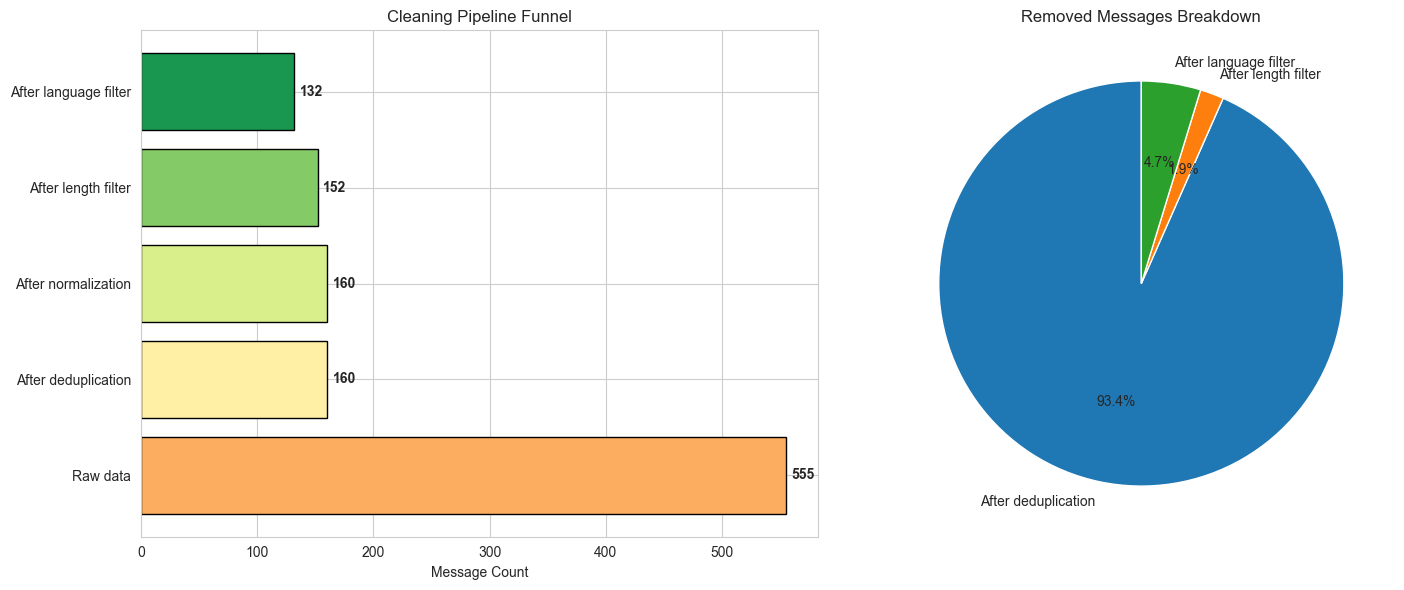

In [11]:
# Create cleaning funnel visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: Funnel chart
stages = stats['step']
counts = stats['count']
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(stages)))

axes[0].barh(stages, counts, color=colors, edgecolor='black')
axes[0].set_xlabel('Message Count')
axes[0].set_title('Cleaning Pipeline Funnel')
for i, (stage, count) in enumerate(zip(stages, counts)):
    axes[0].text(count + 5, i, f'{count}', va='center', fontweight='bold')

# Right: Removal breakdown
removal_labels = stats['step'][1:]
removal_counts = stats['removed'][1:]
non_zero = [(l, c) for l, c in zip(removal_labels, removal_counts) if c > 0]

if non_zero:
    labels, counts = zip(*non_zero)
    axes[1].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[1].set_title('Removed Messages Breakdown')
else:
    axes[1].text(0.5, 0.5, 'No removals', ha='center', va='center')
    axes[1].set_title('Removed Messages Breakdown')

plt.tight_layout()
viz_dir = Path('../outputs/visualizations')
viz_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(viz_dir / '02_cleaning_funnel.png', dpi=100, bbox_inches='tight')
plt.show()

## 12. Text Length Distribution (Cleaned)

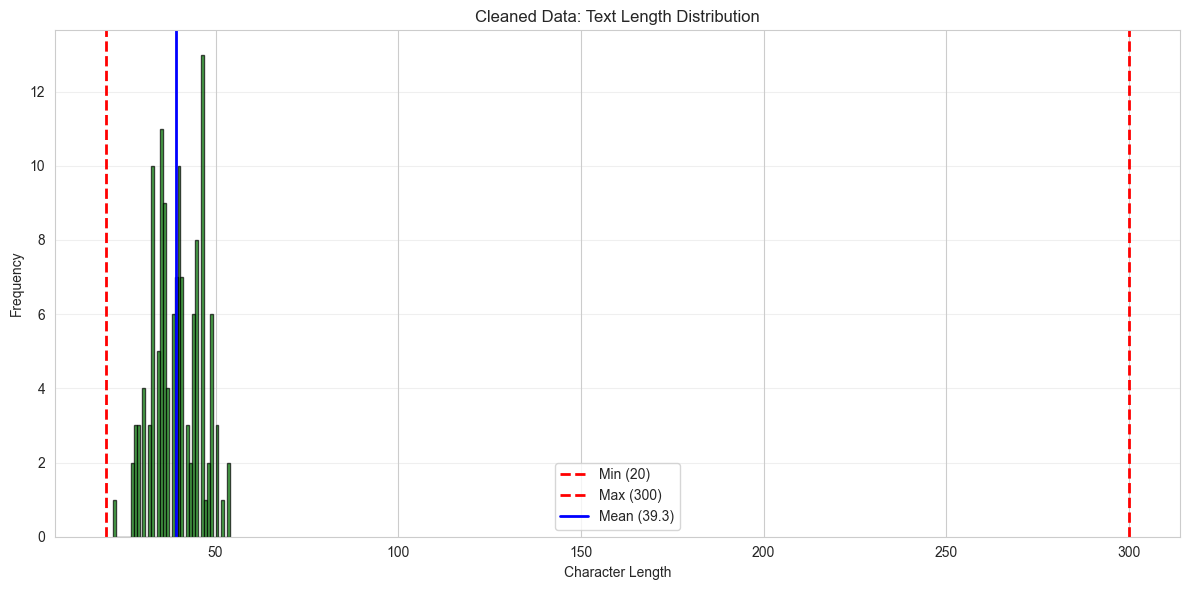

Average text length: 39.31 characters
Median text length: 39 characters


In [12]:
# Visualize cleaned data length distribution
plt.figure(figsize=(12, 6))

plt.hist(df_clean['text_length'], bins=40, edgecolor='black', alpha=0.7, color='green')
plt.axvline(min_len, color='r', linestyle='--', linewidth=2, label=f'Min ({min_len})')
plt.axvline(max_len, color='r', linestyle='--', linewidth=2, label=f'Max ({max_len})')
plt.axvline(df_clean['text_length'].mean(), color='blue', linestyle='-', 
            linewidth=2, label=f'Mean ({df_clean["text_length"].mean():.1f})')

plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Cleaned Data: Text Length Distribution')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(viz_dir / '02_length_distribution_cleaned.png', dpi=100, bbox_inches='tight')
plt.show()

print(f"Average text length: {df_clean['text_length'].mean():.2f} characters")
print(f"Median text length: {df_clean['text_length'].median():.0f} characters")

## 13. Sample Cleaned Messages

In [13]:
print("\nCleaned Message Samples:")
print("="*80)

for idx, row in df_clean.sample(min(10, len(df_clean))).iterrows():
    print(f"\n[{row['id']}] ({row['text_length']} chars, {row['detected_lang']})")
    print(f"{row['text']}")
    print("-" * 80)


Cleaned Message Samples:

[msg_434] (44 chars, id)
AKUN KENA SUSPEND UANG DALEM NYA GIMANA!!!!!
--------------------------------------------------------------------------------

[msg_139] (40 chars, id)
REFUND GW MANA KONTOL UDAH SEMINGGU.....
--------------------------------------------------------------------------------

[msg_359] (45 chars, id)
tolong akun gw di banned ga bisa login urgent
--------------------------------------------------------------------------------

[msg_259] (40 chars, id)
limit transfer gopay berapa sih maksimal
--------------------------------------------------------------------------------

[msg_417] (46 chars, id)
uang nyangkut 1.5jt transaksi gagal urgent min
--------------------------------------------------------------------------------

[msg_090] (42 chars, id)
top up gagal tapi rekening kepotong tai!!!
--------------------------------------------------------------------------------

[msg_414] (38 chars, id)
AKUN GW SUSPEND PADAHAL GA NGAPA2IN!!!
----

## 14. Completion & Next Steps

In [14]:
print("\n" + "="*60)
print("CLEANING PIPELINE COMPLETED")
print("="*60)
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nOutputs generated:")
print(f"  1. {output_jsonl}")
print(f"  2. {validation_path}")
print(f"  3. {log_path}")
print(f"  4. {viz_dir}/02_cleaning_funnel.png")
print(f"  5. {viz_dir}/02_length_distribution_cleaned.png")
print(f"\nCleaned messages ready for labeling: {len(df_clean)}")
print("\nNext step: Day 3 - Manual labeling (intent, sentiment, urgency, safety)")
print("="*60)


CLEANING PIPELINE COMPLETED
Timestamp: 2025-12-19 10:07:30

Outputs generated:
  1. ..\data\processed\cleaned_data.jsonl
  2. ..\data\processed\validation_report.json
  3. ..\data\processed\cleaning_log.csv
  4. ..\outputs\visualizations/02_cleaning_funnel.png
  5. ..\outputs\visualizations/02_length_distribution_cleaned.png

Cleaned messages ready for labeling: 132

Next step: Day 3 - Manual labeling (intent, sentiment, urgency, safety)
